Piyakorn Mona Munegan

Kaggle user name: Mona Munegan https://www.kaggle.com/piyakornmunegan

A code stub for accessing the dataset:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory

from google.colab import drive
import time

import pickle
import json

drive.mount('/content/drive/')

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral', 'OTHER']
no_class = 7
dataset_directory = '/content/drive/My Drive/COMP8220/Project/data/facial-expression-recognition-indom/'  ## CHANGE TO YOUR OWN DIRECTORY
saved_model_directory = '/content/drive/My Drive/COMP8220/Project/savedmodel/'

Mounted at /content/drive/


In [ ]:
#os.chdir('/content/drive/My Drive/COMP8220/Project/savedmodel/')

# Data Exploration

In [ ]:
images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

#PublicTest set
images_test_public = np.load(join(dataset_directory, 'PublicTest_faces_only_data_images.npy'))  ## CHANGE TO APPROPRIATE PUBLIC TEST FILE

images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size]) 
print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)
print(f'Dataset has {images_train.shape[1]*images_train.shape[2]} features') #Mona

(9328, 48, 48)
(9328,)
(1136, 48, 48)
Dataset has 2304 features


## Original dataset

In [ ]:
sample = 1
print(images_train[sample])
print(labels_train[sample])
print(EMOTIONS[labels_train[sample]])

[[0.77647059 0.77647059 0.77647059 ... 0.78039216 0.78039216 0.78431373]
 [0.         0.         0.         ... 0.07843137 0.06666667 0.78039216]
 [0.00392157 0.         0.         ... 0.09019608 0.08627451 0.78039216]
 ...
 [0.         0.         0.         ... 0.1254902  0.10196078 0.78039216]
 [0.         0.         0.         ... 0.12156863 0.10196078 0.78039216]
 [0.         0.         0.         ... 0.11372549 0.10196078 0.78039216]]
6
neutral


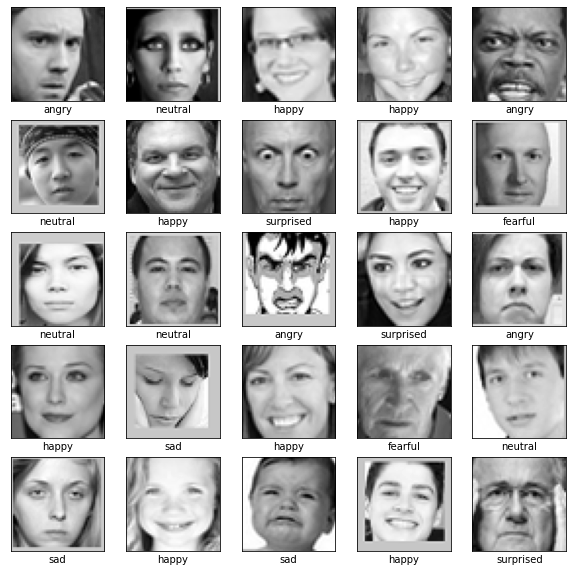

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

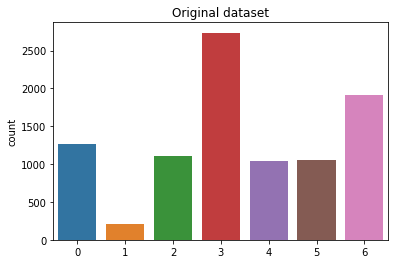

In [ ]:
fig, ax = plt.figsize=(20,5)
labels_train.shape = len(labels_train)
ax = sns.countplot(x=labels_train).set_title('Original dataset')
#ax1.set_xticklabels(emotions.values())

## FER2013

In [14]:
filname = '/content/drive/My Drive/COMP8220/Project/data/fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/My Drive/COMP8220/Project/data/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [15]:
#get data from csv function from #https://www.kaggle.com/code/shawon10/facial-expression-detection-cnn/notebook

def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [16]:
FER2013_images, FER2013_labels = getData(filname)
num_class = len(set(FER2013_labels))
print(num_class)

7


In [17]:
print(FER2013_images.shape)
print(FER2013_labels.shape)

(35887, 2304)
(35887,)


In [18]:
FER2013_images = FER2013_images.reshape([-1, image_size, image_size])
print(FER2013_images.shape)

(35887, 48, 48)


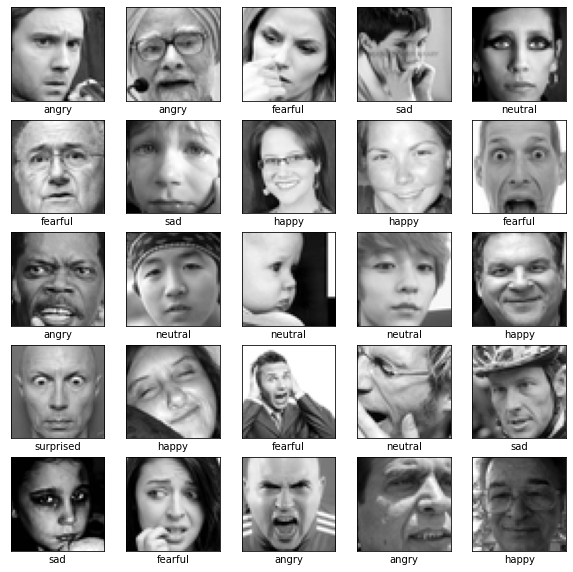

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(FER2013_images[i], cmap='gray')
    plt.xlabel( EMOTIONS[ FER2013_labels[i] ] )
plt.show()

# Data Preparation

## Original dataset

In [ ]:
#(n_samples, height, width, channels)
images_train = images_train.reshape(-1, 48, 48, 1)

In [ ]:
X_test, X_train_full = images_train[:1000], images_train[1000:]
y_test, y_train_full = labels_train[:1000], labels_train[1000:]

In [ ]:
print(X_train_full.shape)
print(X_test.shape)
print(y_train_full.shape)
print(y_test.shape)

(8328, 48, 48, 1)
(1000, 48, 48, 1)
(8328,)
(1000,)


In [ ]:
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_valid, X_train = X_train_full[:2000], X_train_full[2000:]
y_valid, y_train = y_train_full[:2000], y_train_full[2000:]

In [ ]:
#~70/20/10
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(6328, 48, 48, 1)
(6328,)
(2000, 48, 48, 1)
(2000,)
(1000, 48, 48, 1)
(1000,)


In [ ]:
#EMOTIONS dictionary
emotions = {0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'}

[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

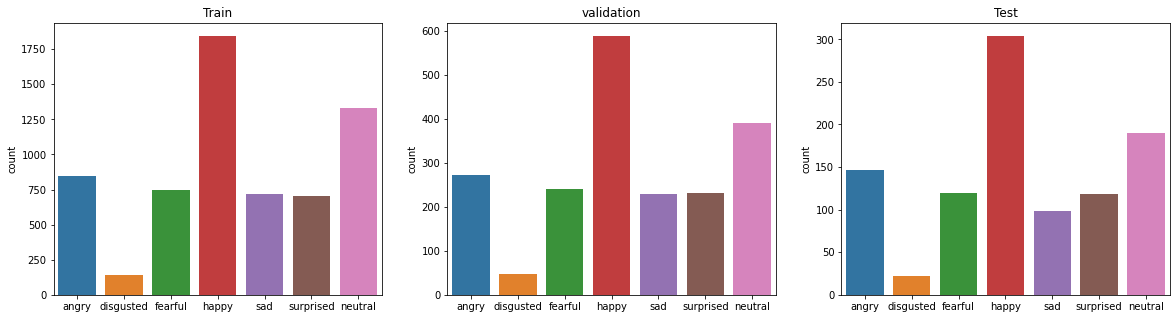

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values())
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values())
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values())

## FER2013

In [20]:
#(n_samples, height, width, channels)
FER2013_images = FER2013_images.reshape(-1, 48, 48, 1)

In [21]:
print(FER2013_images.shape)
print(FER2013_labels.shape)

(35887, 48, 48, 1)
(35887,)


In [22]:
X_test, X_train_full = FER2013_images[:3500], FER2013_images[3500:]
y_test, y_train_full = FER2013_labels[:3500], FER2013_labels[3500:]

In [23]:
X_valid, X_train = X_train_full[:7000], X_train_full[7000:]
y_valid, y_train = y_train_full[:7000], y_train_full[7000:]

In [12]:
#~70/20/10
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(25387, 48, 48, 1)
(25387,)
(7000, 48, 48, 1)
(7000,)
(3500, 48, 48, 1)
(3500,)


[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

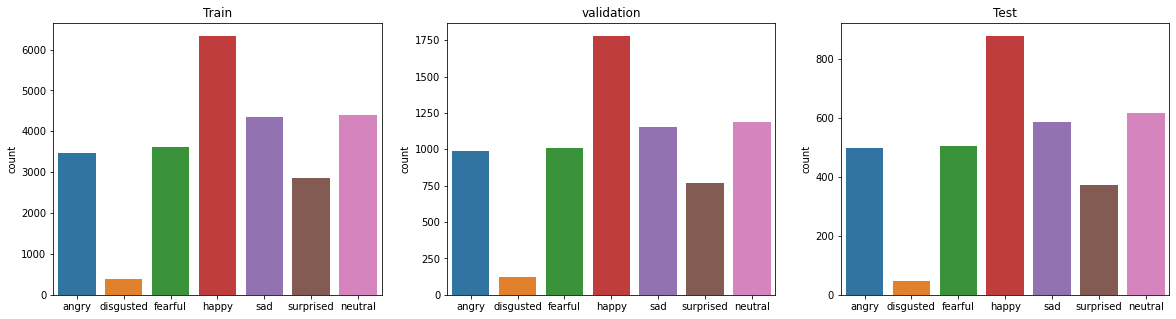

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values())
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values())
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values())

## Enlarge dataset

In [ ]:
#Concat original and FER2013 image train
images_train_plus_FER2013 = np.concatenate((images_train, FER2013_images), axis=0)
#Concat original and FER2013 labels train
labels_train_plus_FER2013 = np.concatenate((labels_train, FER2013_labels), axis=0)

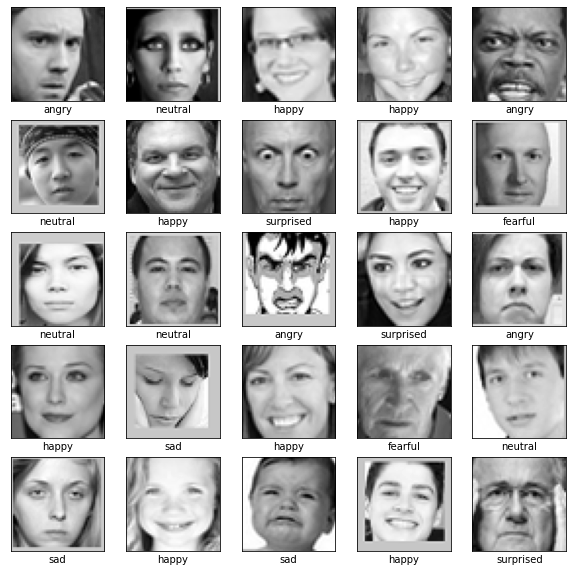

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train_plus_FER2013[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train_plus_FER2013[i] ] )
plt.show()

[[0.21568627 0.34901961 0.36470588 ... 0.0627451  0.0627451  0.0627451 ]
 [0.19215686 0.33333333 0.27058824 ... 0.0627451  0.0627451  0.0627451 ]
 [0.17254902 0.36078431 0.20784314 ... 0.0627451  0.0627451  0.0627451 ]
 ...
 [0.06666667 0.06666667 0.06666667 ... 0.04313725 0.04705882 0.05098039]
 [0.06666667 0.06666667 0.06666667 ... 0.05098039 0.05490196 0.05490196]
 [0.0627451  0.06666667 0.06666667 ... 0.06666667 0.05490196 0.0627451 ]]
5
surprised


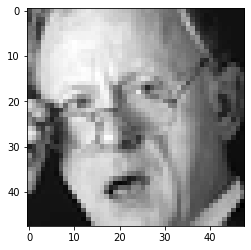

In [ ]:
sample = 12345
print(images_train_plus_FER2013[sample])
print(labels_train_plus_FER2013[sample])
print(EMOTIONS[labels_train_plus_FER2013[sample]])
plt.imshow(images_train_plus_FER2013[sample], cmap='gray')

Text(0.5, 1.0, 'Original dataset+FER2013')

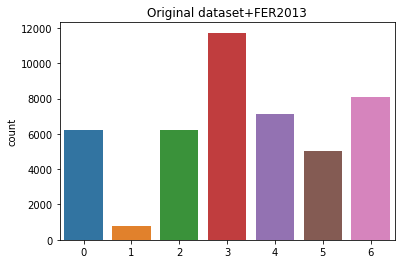

In [ ]:
sns.countplot(x=labels_train_plus_FER2013).set_title('Original dataset+FER2013')

In [ ]:
#(n_samples, height, width, channels)
images_train_plus_FER2013 = images_train_plus_FER2013.reshape(-1, 48, 48, 1)

In [ ]:
print(images_train_plus_FER2013.shape)
print(labels_train_plus_FER2013.shape)

(45215, 48, 48, 1)
(45215,)


In [ ]:
X_test, X_train_full = images_train_plus_FER2013[:5000], images_train_plus_FER2013[5000:]
y_test, y_train_full = labels_train_plus_FER2013[:5000], labels_train_plus_FER2013[5000:]

In [ ]:
print(X_train_full.shape)
print(X_test.shape)
print(y_train_full.shape)
print(y_test.shape)

(40215, 48, 48, 1)
(5000, 48, 48, 1)
(40215,)
(5000,)


In [ ]:
X_valid, X_train = X_train_full[:9000], X_train_full[9000:]
y_valid, y_train = y_train_full[:9000], y_train_full[9000:]

In [ ]:
#~70/20/10
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(31215, 48, 48, 1)
(31215,)
(9000, 48, 48, 1)
(9000,)
(5000, 48, 48, 1)
(5000,)


[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral')]

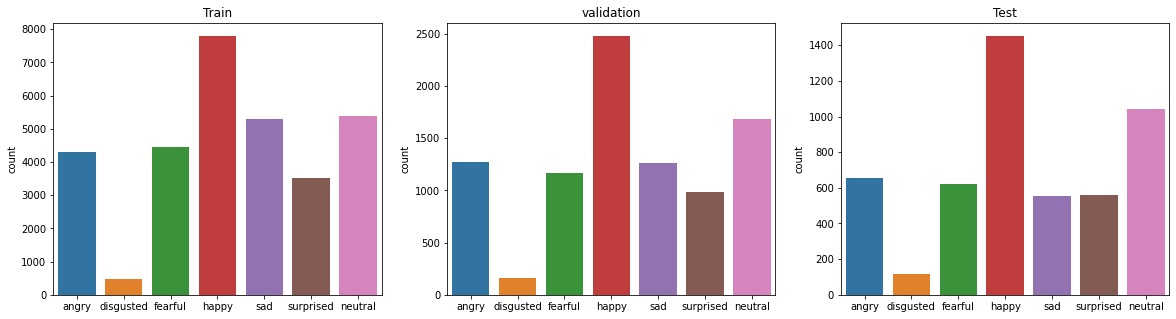

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values())
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values())
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values())

# Model bulding

##CNN

#Feature mapping calculation

In [24]:
X_train.shape

(25387, 48, 48, 1)

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, activation="relu", strides=2),
    keras.layers.MaxPool2D(strides=2, padding="valid"),
    keras.layers.Conv2D(32, kernel_size=3, activation="relu", strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/2
794/794 [==============================] - 16s 5ms/step - loss: 1.6993 - accuracy: 0.3295 - val_loss: 1.6246 - val_accuracy: 0.3676
Epoch 2/2
110/110 [==============================] - 0s 3ms/step - loss: 1.5074 - accuracy: 0.4137


[1.5074161291122437, 0.41371428966522217]

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 128)               102528    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 23, 32)        128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 11, 32)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 11, 5, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 1760)              0         
                                                                 
 dense (Dense)               (None, 128)               225408    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="valid", activation="relu", strides=2),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size=3, padding="valid", activation="relu", strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/2
794/794 [==============================] - 6s 6ms/step - loss: 1.5958 - accuracy: 0.3777 - val_loss: 1.5850 - val_accuracy: 0.3599
Epoch 2/2
110/110 [==============================] - 0s 3ms/step - loss: 1.3818 - accuracy: 0.4760


[1.3817778825759888, 0.47600001096725464]

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 14112)             0         
                                                                 
 dense (Dense)               (None, 128)               1806464   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

###Simple CNN

In [1]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation= "relu", input_shape=[224, 224, 1]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.Dense(100, activation="sigmoid"),
    keras.layers.Dense(no_class, activation="softmax") #pick the highest prob.
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#n_epochs = 2
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

NameError: ignored

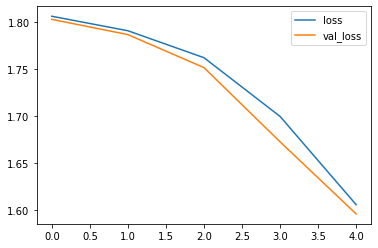

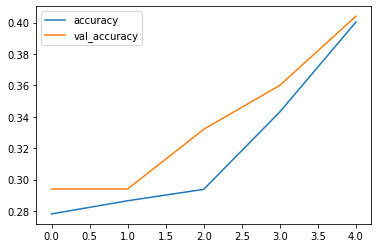

In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 1.5930 - accuracy: 0.4040


[1.5929735898971558, 0.40400001406669617]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.2 , 0.02, 0.11, 0.13, 0.14, 0.08, 0.32],
       [0.11, 0.02, 0.08, 0.04, 0.12, 0.09, 0.53],
       [0.07, 0.02, 0.05, 0.54, 0.06, 0.05, 0.21]], dtype=float32)

In [ ]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
np.argmax(y_pred[0])

0

In [ ]:
np.array(EMOTIONS)[y_pred[0]]

array(['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry'],
      dtype='<U9')

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
#np.array(EMOTIONS)[y_pred]

In [ ]:
result = []
for i in range(len(y_pred)):
  r = np.argmax(y_pred[i])
  result.append(r)
arr = np.array(result)
#arr

In [ ]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

### CNN 1

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/10
198/198 [==============================] - 3s 10ms/step - loss: 1.8204 - accuracy: 0.2786 - val_loss: 1.8067 - val_accuracy: 0.2940
Epoch 2/10
198/198 [==============================] - 2s 9ms/step - loss: 1.8025 - accuracy: 0.2878 - val_loss: 1.7996 - val_accuracy: 0.2940
Epoch 3/10
198/198 [==============================] - 2s 9ms/step - loss: 1.8014 - accuracy: 0.2911 - val_loss: 1.8112 - val_accuracy: 0.2940
Epoch 4/10
198/198 [==============================] - 2s 9ms/step - loss: 1.7989 - accuracy: 0.2911 - val_loss: 1.7922 - val_accuracy: 0.2940
Epoch 5/10
198/198 [==============================] - 2s 9ms/step - loss: 1.7945 - accuracy: 0.2914 - val_loss: 1.7922 - val_accuracy: 0.2940
Epoch 6/10
198/198 [==============================] - 2s 9ms/step - loss: 1.7917 - accuracy: 0.2914 - val_loss: 1.7921 - val_accuracy: 0.2940
Epoch 7/10
198/198 [==============================] - 2s 9ms/step - loss: 1.7921 - accuracy: 0.2914 - val_loss: 1.7917 - val_accuracy: 0.2940
Epoch

[1.7832756042480469, 0.30399999022483826]

32/32 [==============================] - 0s 4ms/step - loss: 1.7833 - accuracy: 0.3040


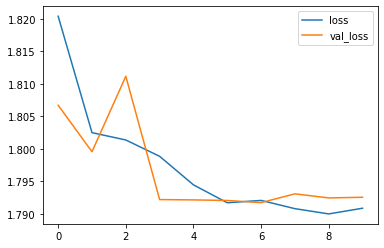

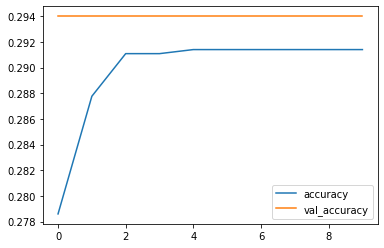

In [ ]:
model.evaluate(X_test, y_test)
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

###  CNN 2

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    
    
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

model.evaluate(X_test, y_test)

Epoch 1/10
198/198 [==============================] - 3s 10ms/step - loss: 1.8148 - accuracy: 0.2814 - val_loss: 1.8015 - val_accuracy: 0.2940
Epoch 2/10
198/198 [==============================] - 2s 8ms/step - loss: 1.8020 - accuracy: 0.2873 - val_loss: 1.7949 - val_accuracy: 0.2940
Epoch 3/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7948 - accuracy: 0.2900 - val_loss: 1.8008 - val_accuracy: 0.2940
Epoch 4/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7949 - accuracy: 0.2920 - val_loss: 1.7929 - val_accuracy: 0.2940
Epoch 5/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7937 - accuracy: 0.2912 - val_loss: 1.7924 - val_accuracy: 0.2940
Epoch 6/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7934 - accuracy: 0.2914 - val_loss: 1.7920 - val_accuracy: 0.2940
Epoch 7/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7909 - accuracy: 0.2912 - val_loss: 1.7921 - val_accuracy: 0.2940
Epoch

[1.7827379703521729, 0.30399999022483826]

32/32 [==============================] - 0s 4ms/step - loss: 1.7827 - accuracy: 0.3040


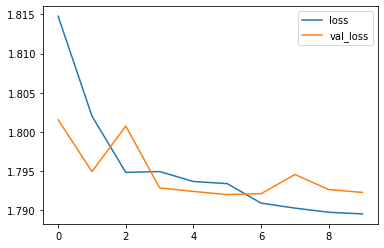

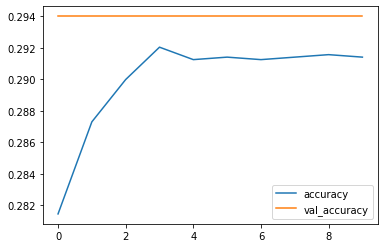

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### LearningRateScheduler

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    
    
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(no_class, activation="softmax")
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20)) 

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])
model.evaluate(X_test, y_test)

Epoch 1/10
198/198 [==============================] - 3s 9ms/step - loss: 1.8147 - accuracy: 0.2807 - val_loss: 1.8013 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 2/10
198/198 [==============================] - 2s 8ms/step - loss: 1.8024 - accuracy: 0.2884 - val_loss: 1.7958 - val_accuracy: 0.2940 - lr: 0.0011
Epoch 3/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7948 - accuracy: 0.2893 - val_loss: 1.8018 - val_accuracy: 0.2940 - lr: 0.0013
Epoch 4/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7958 - accuracy: 0.2924 - val_loss: 1.7928 - val_accuracy: 0.2940 - lr: 0.0014
Epoch 5/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7949 - accuracy: 0.2914 - val_loss: 1.7927 - val_accuracy: 0.2940 - lr: 0.0016
Epoch 6/10
198/198 [==============================] - 2s 8ms/step - loss: 1.7933 - accuracy: 0.2889 - val_loss: 1.7923 - val_accuracy: 0.2940 - lr: 0.0018
Epoch 7/10
198/198 [==============================] - 2s 8ms/step - lo

[1.7828704118728638, 0.30399999022483826]

32/32 [==============================] - 0s 4ms/step - loss: 1.7829 - accuracy: 0.3040


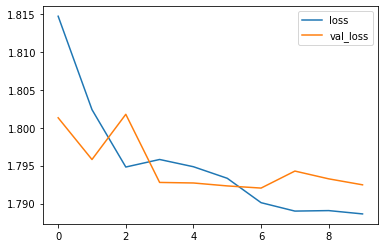

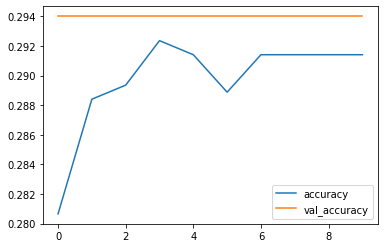

In [ ]:

model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### CNN 3

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])


### Eearly_stopping, lr_scheduler declaration

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

#### Data Augmentation

In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
197/197 [==============================] - 9s 23ms/step - loss: 2.2080 - accuracy: 0.2201 - val_loss: 4.2427 - val_accuracy: 0.1955 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 4s 20ms/step - loss: 1.9151 - accuracy: 0.2655 - val_loss: 2.9958 - val_accuracy: 0.1955 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 4s 20ms/step - loss: 1.8671 - accuracy: 0.2827 - val_loss: 2.1142 - val_accuracy: 0.2945 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 4s 20ms/step - loss: 1.8004 - accuracy: 0.3039 - val_loss: 1.6789 - val_accuracy: 0.3740 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 4s 20ms/step - loss: 1.7214 - accuracy: 0.3454 - val_loss: 1.5889 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 4s 21ms/step - loss: 1.6639 - accuracy: 0.3729 - val_loss: 1.4998 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 7/100
197/197 [==============================] - 4s 

[0.9898447394371033, 0.6439999938011169]

32/32 [==============================] - 0s 6ms/step - loss: 0.9898 - accuracy: 0.6440


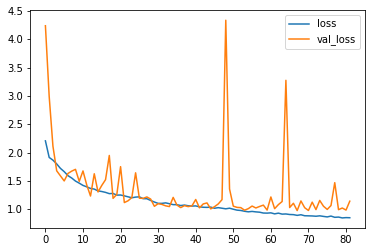

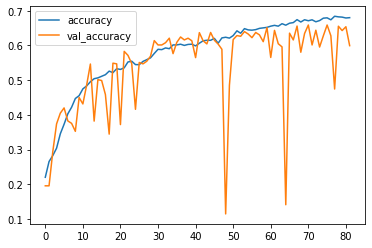

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### Data Augmentation2

In [ ]:
#ImageDataGenerator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

earlystopping = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(X_train, y_train, 64),
                                steps_per_epoch=len(X_train) / 64,
                                epochs=50,
                                callbacks = [earlystopping],
                                validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/50
98/98 [==============================] - 7s 40ms/step - loss: 2.2296 - accuracy: 0.2336 - val_loss: 2.3340 - val_accuracy: 0.2940
Epoch 2/50
98/98 [==============================] - 3s 34ms/step - loss: 1.9326 - accuracy: 0.2845 - val_loss: 3.3501 - val_accuracy: 0.1955
Epoch 3/50
98/98 [==============================] - 3s 35ms/step - loss: 1.8166 - accuracy: 0.3168 - val_loss: 4.5874 - val_accuracy: 0.2940
Epoch 4/50
98/98 [==============================] - 4s 36ms/step - loss: 1.7111 - accuracy: 0.3657 - val_loss: 2.9537 - val_accuracy: 0.2940
Epoch 5/50
98/98 [==============================] - 3s 35ms/step - loss: 1.6097 - accuracy: 0.4034 - val_loss: 2.8897 - val_accuracy: 0.2940
Epoch 6/50
98/98 [==============================] - 3s 34ms/step - loss: 1.5548 - accuracy: 0.4234 - val_loss: 2.5870 - val_accuracy: 0.2650
Epoch 7/50
98/98 [==============================] - 3s 35ms/step - loss: 1.5011 - accuracy: 0.4447 - val_loss: 1.9761 - val_accuracy: 0.4120
Epoch 8/50
98

[1.1117888689041138, 0.5989999771118164]

32/32 [==============================] - 0s 5ms/step - loss: 1.1118 - accuracy: 0.5990


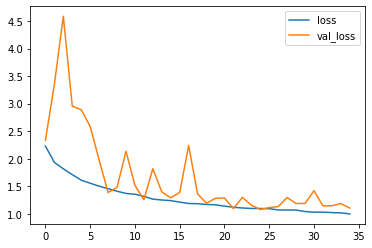

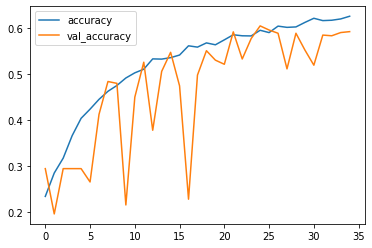

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
#model.summary()

### CNN4

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])


model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])


In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
197/197 [==============================] - 8s 21ms/step - loss: 2.1857 - accuracy: 0.2332 - val_loss: 2.8087 - val_accuracy: 0.1955 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 4s 20ms/step - loss: 1.8908 - accuracy: 0.2859 - val_loss: 2.5642 - val_accuracy: 0.2805 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 4s 19ms/step - loss: 1.7669 - accuracy: 0.3292 - val_loss: 2.2219 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 4s 19ms/step - loss: 1.6650 - accuracy: 0.3783 - val_loss: 1.7968 - val_accuracy: 0.3190 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 4s 19ms/step - loss: 1.6060 - accuracy: 0.3992 - val_loss: 2.1382 - val_accuracy: 0.2385 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 4s 20ms/step - loss: 1.5294 - accuracy: 0.4290 - val_loss: 6.5579 - val_accuracy: 0.1175 - lr: 0.0010
Epoch 7/100
197/197 [==============================] - 4s 

[1.0186630487442017, 0.640999972820282]

32/32 [==============================] - 0s 5ms/step - loss: 1.0187 - accuracy: 0.6410


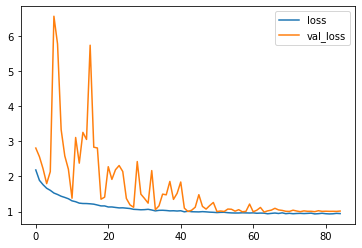

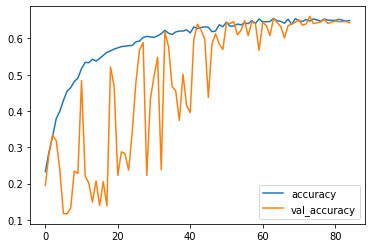

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN4_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN4_accuracy.jpg')

In [ ]:
# Save and load history obj. Dr. Fabien Tarrade https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

In [ ]:
model.save(saved_model_directory+'CNN4.h5')

with open(saved_model_directory +'/history_CNN4', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

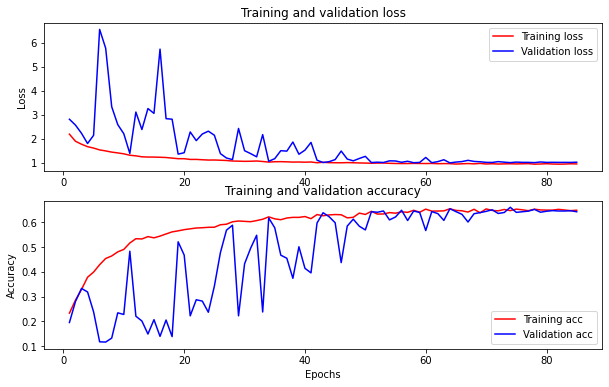

In [ ]:
with open(saved_model_directory +'/history_CNN4', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN4.jpg')

### CNN5

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])

#### Data Augmentation

In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

In [ ]:
batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
197/197 [==============================] - 9s 26ms/step - loss: 2.5299 - accuracy: 0.2088 - val_loss: 1.9880 - val_accuracy: 0.1145 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 5s 22ms/step - loss: 2.0288 - accuracy: 0.2699 - val_loss: 1.9597 - val_accuracy: 0.2955 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 4s 21ms/step - loss: 1.8344 - accuracy: 0.3156 - val_loss: 1.7443 - val_accuracy: 0.2885 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 4s 21ms/step - loss: 1.7201 - accuracy: 0.3530 - val_loss: 1.5830 - val_accuracy: 0.3900 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 4s 21ms/step - loss: 1.6400 - accuracy: 0.3846 - val_loss: 1.8355 - val_accuracy: 0.2790 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 4s 21ms/step - loss: 1.5615 - accuracy: 0.4208 - val_loss: 1.9939 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 7/100
197/197 [==============================] - 4s 

[0.9625545144081116, 0.6610000133514404]

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

32/32 [==============================] - 0s 8ms/step - loss: 0.9626 - accuracy: 0.6610


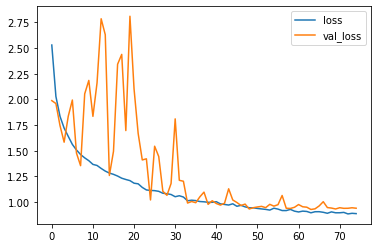

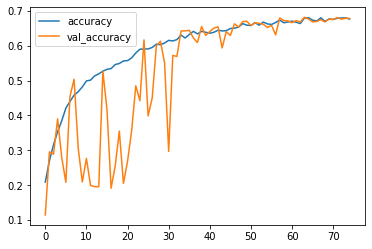

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN5_1_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN5_1_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN5_1.h5')

with open(saved_model_directory +'/historyCNN5_1', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

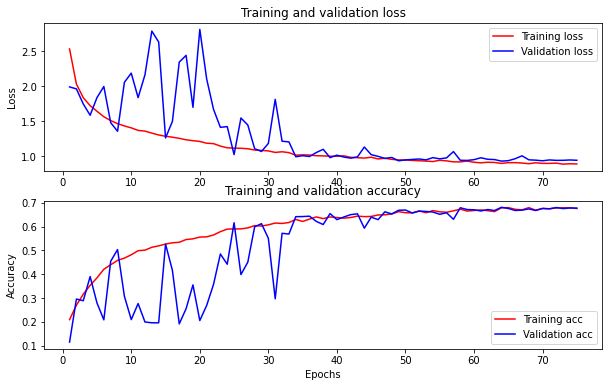

In [ ]:
with open(saved_model_directory +'/historyCNN5_1', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN5_1.jpg')

#### Data Augmentation2

In [ ]:
data_generator2 = ImageDataGenerator(
                        #featurewise_center=False,
                        #featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
197/197 [==============================] - 9s 23ms/step - loss: 2.5077 - accuracy: 0.2227 - val_loss: 2.1006 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 4s 21ms/step - loss: 1.9615 - accuracy: 0.3097 - val_loss: 9.0701 - val_accuracy: 0.1365 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 4s 21ms/step - loss: 1.7186 - accuracy: 0.3748 - val_loss: 1.8389 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 4s 21ms/step - loss: 1.5796 - accuracy: 0.4235 - val_loss: 1.3835 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 4s 21ms/step - loss: 1.5074 - accuracy: 0.4418 - val_loss: 1.5959 - val_accuracy: 0.3995 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 4s 21ms/step - loss: 1.4424 - accuracy: 0.4692 - val_loss: 1.3832 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 7/100
197/197 [==============================] - 4s 

[0.9565340280532837, 0.6579999923706055]

32/32 [==============================] - 0s 6ms/step - loss: 0.9565 - accuracy: 0.6580


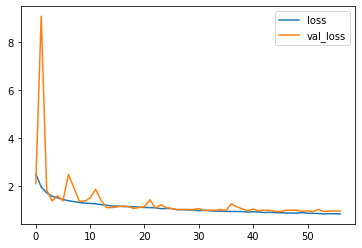

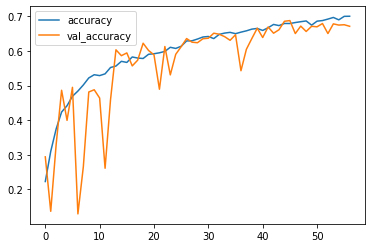

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN5_2_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN5_2_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN5_2.h5')

with open(saved_model_directory +'/history_CNN5_2', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

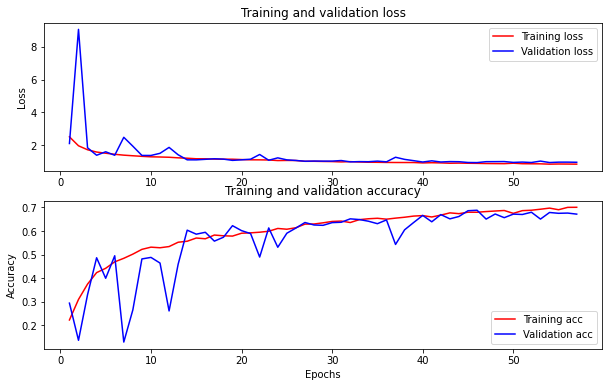

In [ ]:
with open(saved_model_directory +'/history_CNN5_2', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN5_2.jpg')

#### Data Augmentation3

In [ ]:
data_generator3 = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator3.fit(X_train)

batch_size = 32 
history = model.fit(data_generator3.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
197/197 [==============================] - 8s 23ms/step - loss: 2.4770 - accuracy: 0.2222 - val_loss: 3.4905 - val_accuracy: 0.1365 - lr: 0.0010
Epoch 2/100
197/197 [==============================] - 4s 21ms/step - loss: 1.9243 - accuracy: 0.3108 - val_loss: 2.0536 - val_accuracy: 0.2940 - lr: 0.0010
Epoch 3/100
197/197 [==============================] - 4s 21ms/step - loss: 1.6944 - accuracy: 0.3802 - val_loss: 1.5992 - val_accuracy: 0.4265 - lr: 0.0010
Epoch 4/100
197/197 [==============================] - 4s 21ms/step - loss: 1.5769 - accuracy: 0.4148 - val_loss: 1.4993 - val_accuracy: 0.4410 - lr: 0.0010
Epoch 5/100
197/197 [==============================] - 4s 21ms/step - loss: 1.5055 - accuracy: 0.4336 - val_loss: 1.5057 - val_accuracy: 0.4405 - lr: 0.0010
Epoch 6/100
197/197 [==============================] - 4s 21ms/step - loss: 1.4449 - accuracy: 0.4673 - val_loss: 1.3843 - val_accuracy: 0.4785 - lr: 0.0010
Epoch 7/100
197/197 [==============================] - 4s 

[0.9312562346458435, 0.6840000152587891]

32/32 [==============================] - 0s 6ms/step - loss: 0.9313 - accuracy: 0.6840


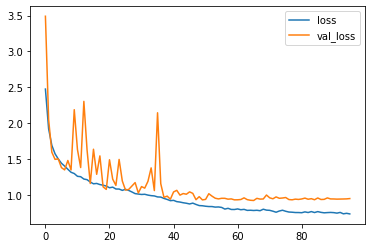

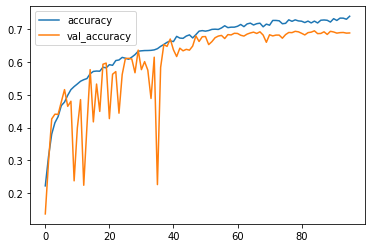

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN5_3_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN5_3_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN5_3.h5')

with open(saved_model_directory +'/history_CNN5_3', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

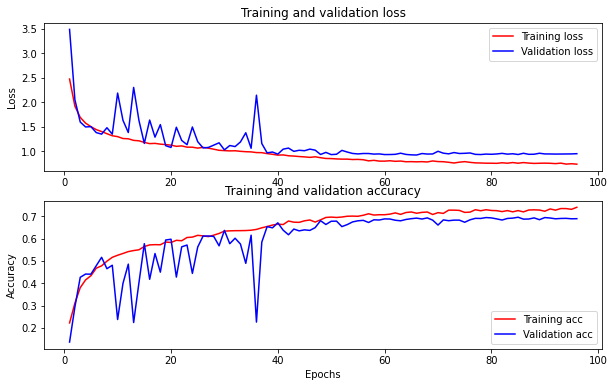

In [ ]:
with open(saved_model_directory +'/history_CNN5_3', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN5_3.jpg')

#Train model using larger dataset(FER2013)

## CNN5

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


### Data Augmentation

In [ ]:
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
793/793 [==============================] - 22s 23ms/step - loss: 2.1383 - accuracy: 0.2261 - val_loss: 1.6686 - val_accuracy: 0.3453 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 15s 19ms/step - loss: 1.7067 - accuracy: 0.3219 - val_loss: 1.5407 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 16s 19ms/step - loss: 1.5519 - accuracy: 0.3934 - val_loss: 1.4135 - val_accuracy: 0.4703 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 16s 19ms/step - loss: 1.4320 - accuracy: 0.4529 - val_loss: 1.2419 - val_accuracy: 0.5313 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 16s 20ms/step - loss: 1.3637 - accuracy: 0.4786 - val_loss: 1.2360 - val_accuracy: 0.5481 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 16s 19ms/step - loss: 1.3151 - accuracy: 0.5006 - val_loss: 1.2781 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

[0.9350745677947998, 0.6648571491241455]

110/110 [==============================] - 1s 6ms/step - loss: 0.9351 - accuracy: 0.6649


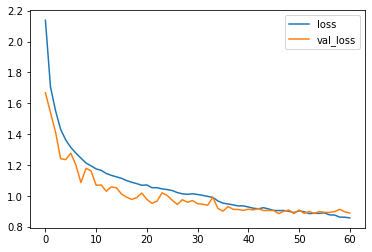

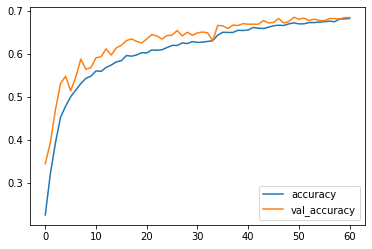

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation2

In [ ]:
data_generator2 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
data_generator2.fit(X_train)

batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

793/793 [==============================] - 20s 21ms/step - loss: 2.0822 - accuracy: 0.2542 - val_loss: 1.5631 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 17s 22ms/step - loss: 1.5973 - accuracy: 0.3824 - val_loss: 1.4378 - val_accuracy: 0.4576 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 17s 21ms/step - loss: 1.4357 - accuracy: 0.4450 - val_loss: 1.3037 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 19s 24ms/step - loss: 1.3582 - accuracy: 0.4784 - val_loss: 1.2456 - val_accuracy: 0.5314 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 17s 21ms/step - loss: 1.3057 - accuracy: 0.5070 - val_loss: 1.2750 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 17s 22ms/step - loss: 1.2613 - accuracy: 0.5244 - val_loss: 1.1534 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 7/100
793/793 [==============================] - 16s 20ms/

[0.9399978518486023, 0.663428544998169]

110/110 [==============================] - 1s 6ms/step - loss: 0.9400 - accuracy: 0.6634


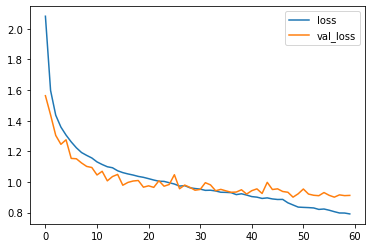

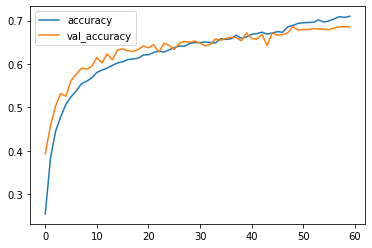

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation3

In [ ]:
data_generator3 = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator3.fit(X_train)

batch_size = 32 
history = model.fit(data_generator3.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
793/793 [==============================] - 20s 20ms/step - loss: 2.0835 - accuracy: 0.2566 - val_loss: 1.5946 - val_accuracy: 0.3813 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 16s 20ms/step - loss: 1.6011 - accuracy: 0.3784 - val_loss: 1.3982 - val_accuracy: 0.4621 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 16s 20ms/step - loss: 1.4501 - accuracy: 0.4412 - val_loss: 1.3021 - val_accuracy: 0.4991 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 16s 20ms/step - loss: 1.3648 - accuracy: 0.4791 - val_loss: 1.2120 - val_accuracy: 0.5406 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 16s 20ms/step - loss: 1.3071 - accuracy: 0.5047 - val_loss: 1.1734 - val_accuracy: 0.5621 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 16s 20ms/step - loss: 1.2655 - accuracy: 0.5238 - val_loss: 1.1745 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

[0.934378445148468, 0.6734285950660706]

110/110 [==============================] - 1s 6ms/step - loss: 0.9404 - accuracy: 0.6689


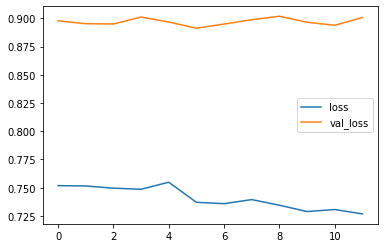

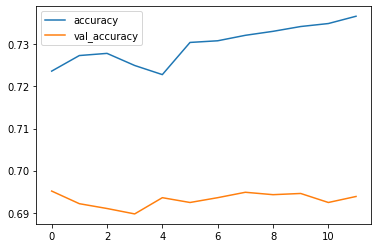

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation4

In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
793/793 [==============================] - 22s 23ms/step - loss: 2.1287 - accuracy: 0.2184 - val_loss: 1.7205 - val_accuracy: 0.3093 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 16s 20ms/step - loss: 1.7562 - accuracy: 0.2877 - val_loss: 1.6815 - val_accuracy: 0.3310 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 16s 20ms/step - loss: 1.6506 - accuracy: 0.3479 - val_loss: 1.6137 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 16s 20ms/step - loss: 1.5322 - accuracy: 0.4014 - val_loss: 1.4142 - val_accuracy: 0.4624 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 16s 20ms/step - loss: 1.4580 - accuracy: 0.4370 - val_loss: 1.3406 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 16s 20ms/step - loss: 1.4010 - accuracy: 0.4624 - val_loss: 1.2858 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

[0.918192982673645, 0.6697142720222473]

110/110 [==============================] - 1s 7ms/step - loss: 0.9182 - accuracy: 0.6697


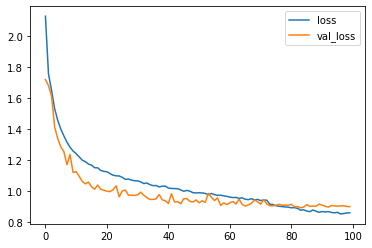

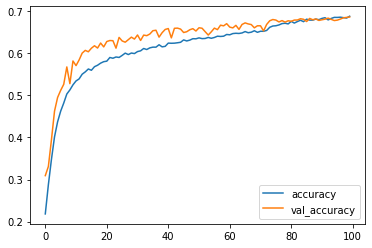

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation5


In [ ]:
data_generator5 = ImageDataGenerator(
                        rotation_range=5,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')
data_generator5.fit(X_train)

batch_size = 32 
history = model.fit(data_generator5.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
793/793 [==============================] - 20s 21ms/step - loss: 2.1638 - accuracy: 0.2079 - val_loss: 1.7592 - val_accuracy: 0.2789 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 17s 21ms/step - loss: 1.8037 - accuracy: 0.2555 - val_loss: 2.0399 - val_accuracy: 0.2866 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 18s 23ms/step - loss: 1.7364 - accuracy: 0.2928 - val_loss: 1.6139 - val_accuracy: 0.3547 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 16s 20ms/step - loss: 1.6514 - accuracy: 0.3429 - val_loss: 1.6241 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 19s 23ms/step - loss: 1.5758 - accuracy: 0.3826 - val_loss: 1.5240 - val_accuracy: 0.4091 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 17s 21ms/step - loss: 1.4965 - accuracy: 0.4250 - val_loss: 1.4412 - val_accuracy: 0.4573 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

[0.9799867868423462, 0.6328571438789368]

110/110 [==============================] - 1s 7ms/step - loss: 0.9800 - accuracy: 0.6329


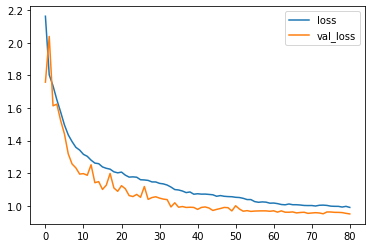

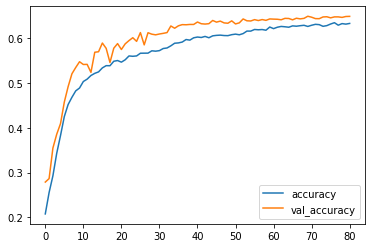

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN6

Reduce the last drop out from 0.6 to 0.4

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 26s 29ms/step - loss: 2.0381 - accuracy: 0.2205 - val_loss: 1.7091 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 21s 27ms/step - loss: 1.7568 - accuracy: 0.2882 - val_loss: 1.7268 - val_accuracy: 0.3247 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 21s 27ms/step - loss: 1.6167 - accuracy: 0.3582 - val_loss: 1.4773 - val_accuracy: 0.4436 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 21s 27ms/step - loss: 1.4902 - accuracy: 0.4244 - val_loss: 1.4840 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 22s 27ms/step - loss: 1.4081 - accuracy: 0.4606 - val_loss: 1.3526 - val_accuracy: 0.5021 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 21s 27ms/step - loss: 1.3455 - accuracy: 0.4885 - val_loss: 1.2753 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 9ms/step - loss: 0.9148 - accuracy: 0.6743


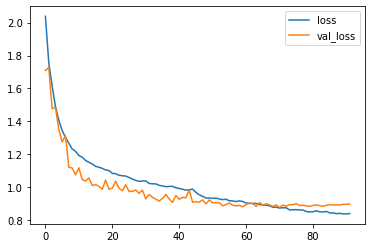

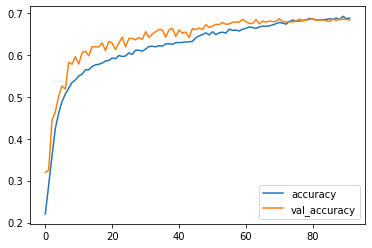

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN7

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 24s 27ms/step - loss: 1.9824 - accuracy: 0.2242 - val_loss: 1.7112 - val_accuracy: 0.3166 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 21s 27ms/step - loss: 1.7480 - accuracy: 0.2934 - val_loss: 1.5905 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 21s 27ms/step - loss: 1.5914 - accuracy: 0.3744 - val_loss: 1.4601 - val_accuracy: 0.4566 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 21s 26ms/step - loss: 1.4662 - accuracy: 0.4340 - val_loss: 1.2705 - val_accuracy: 0.5199 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 21s 27ms/step - loss: 1.3877 - accuracy: 0.4693 - val_loss: 1.2044 - val_accuracy: 0.5421 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 21s 27ms/step - loss: 1.3299 - accuracy: 0.4952 - val_loss: 1.2158 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 8ms/step - loss: 0.9150 - accuracy: 0.6660


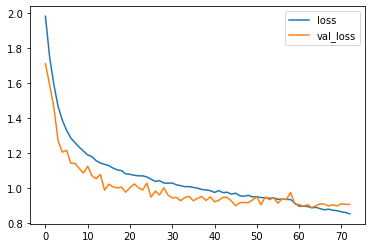

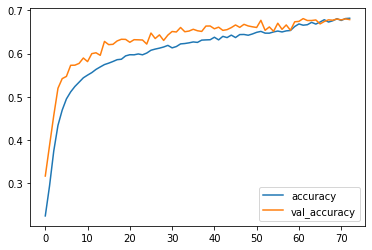

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

##CNN8

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 25s 28ms/step - loss: 2.0798 - accuracy: 0.2198 - val_loss: 1.7264 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 21s 26ms/step - loss: 1.7391 - accuracy: 0.2996 - val_loss: 1.5351 - val_accuracy: 0.3967 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 21s 27ms/step - loss: 1.5703 - accuracy: 0.3845 - val_loss: 1.4990 - val_accuracy: 0.4320 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 21s 26ms/step - loss: 1.4498 - accuracy: 0.4424 - val_loss: 1.2941 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 21s 26ms/step - loss: 1.3624 - accuracy: 0.4782 - val_loss: 1.2273 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 21s 27ms/step - loss: 1.3062 - accuracy: 0.5035 - val_loss: 1.1574 - val_accuracy: 0.5649 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 8ms/step - loss: 0.9635 - accuracy: 0.6769


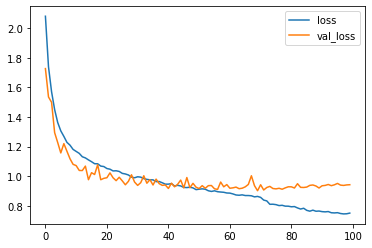

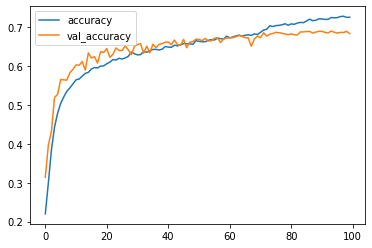

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN9

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 19s 20ms/step - loss: 2.0985 - accuracy: 0.2204 - val_loss: 1.7665 - val_accuracy: 0.2846 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 16s 20ms/step - loss: 1.7436 - accuracy: 0.3018 - val_loss: 1.5817 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 16s 20ms/step - loss: 1.5639 - accuracy: 0.3853 - val_loss: 1.4812 - val_accuracy: 0.4539 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 17s 21ms/step - loss: 1.4493 - accuracy: 0.4397 - val_loss: 1.3145 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 18s 22ms/step - loss: 1.3594 - accuracy: 0.4813 - val_loss: 1.2225 - val_accuracy: 0.5407 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 16s 20ms/step - loss: 1.2994 - accuracy: 0.5048 - val_loss: 1.1317 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 6ms/step - loss: 0.9788 - accuracy: 0.6683


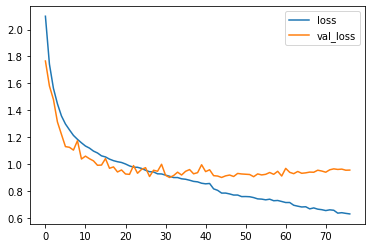

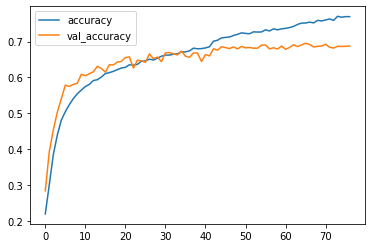

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN9_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN9_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN9.h5')

In [ ]:
with open(saved_model_directory +'/history_CNN9', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(saved_model_directory +'/history_CNN9', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

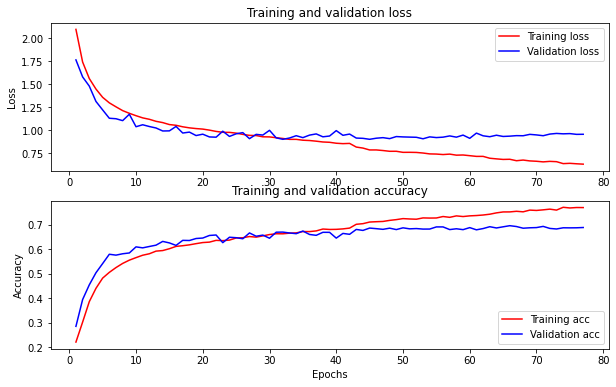

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN9.jpg')

## CNN10

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 18s 19ms/step - loss: 2.1207 - accuracy: 0.2172 - val_loss: 1.7314 - val_accuracy: 0.3031 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 15s 19ms/step - loss: 1.7729 - accuracy: 0.2826 - val_loss: 1.6486 - val_accuracy: 0.3460 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 15s 19ms/step - loss: 1.6459 - accuracy: 0.3461 - val_loss: 1.4877 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 15s 19ms/step - loss: 1.5002 - accuracy: 0.4160 - val_loss: 1.4355 - val_accuracy: 0.4501 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 15s 19ms/step - loss: 1.4232 - accuracy: 0.4509 - val_loss: 1.3298 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 15s 19ms/step - loss: 1.3571 - accuracy: 0.4849 - val_loss: 1.2002 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 6ms/step - loss: 0.8853 - accuracy: 0.6734


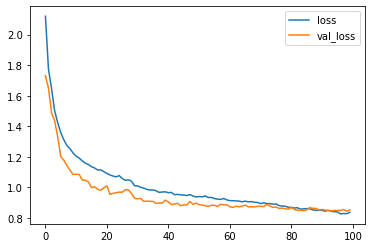

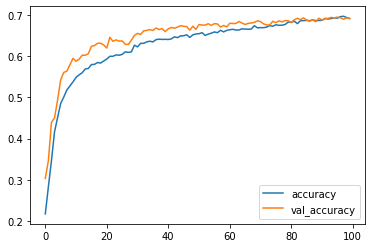

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN10_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN10_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN10.h5')

In [ ]:
with open(saved_model_directory +'/history_CNN10', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(saved_model_directory +'/history_CNN10', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

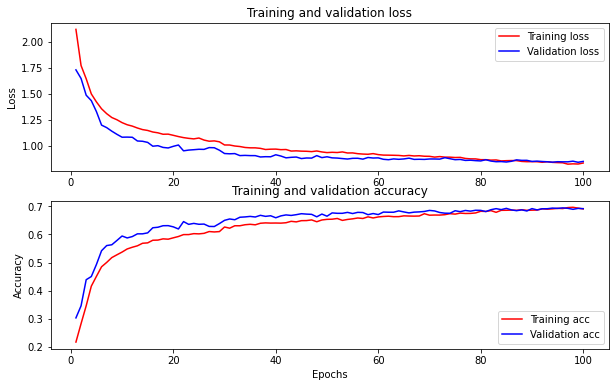

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN10.jpg')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
CNN10_saved = tf.keras.models.load_model(saved_model_directory+'CNN10.h5')

# Show the model architecture
CNN10_saved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

## CNN11

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 20s 21ms/step - loss: 2.2448 - accuracy: 0.2034 - val_loss: 1.7541 - val_accuracy: 0.2814 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 16s 20ms/step - loss: 1.7782 - accuracy: 0.2840 - val_loss: 1.6554 - val_accuracy: 0.3544 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 16s 20ms/step - loss: 1.6172 - accuracy: 0.3630 - val_loss: 1.4820 - val_accuracy: 0.4364 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 16s 20ms/step - loss: 1.5053 - accuracy: 0.4195 - val_loss: 1.3762 - val_accuracy: 0.4779 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 16s 20ms/step - loss: 1.4276 - accuracy: 0.4540 - val_loss: 1.3127 - val_accuracy: 0.4913 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 16s 20ms/step - loss: 1.3767 - accuracy: 0.4763 - val_loss: 1.2162 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 6ms/step - loss: 0.9023 - accuracy: 0.6769


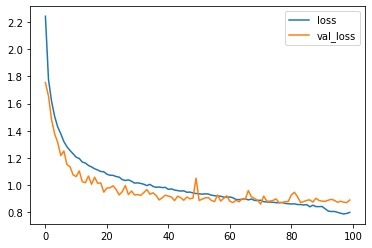

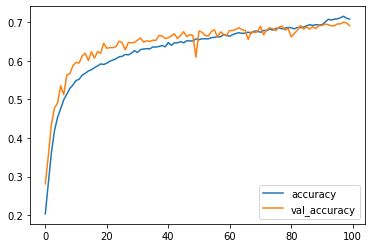

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN11_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN11_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN11.h5')

In [ ]:
with open(saved_model_directory +'/history_CNN11', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

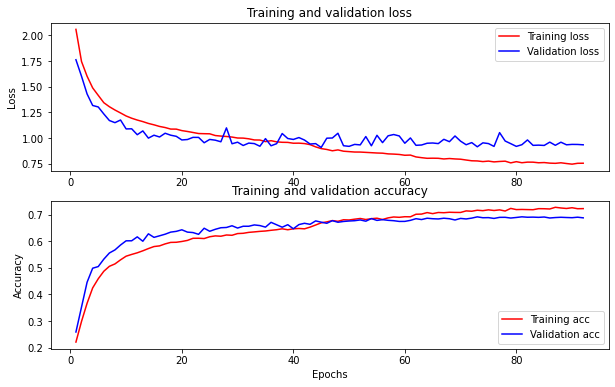

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN11.jpg')

## CNN12

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    #Addition layer
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    #Addition layer
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 21s 21ms/step - loss: 2.2560 - accuracy: 0.1984 - val_loss: 1.7891 - val_accuracy: 0.2681 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 17s 21ms/step - loss: 1.8239 - accuracy: 0.2431 - val_loss: 1.7348 - val_accuracy: 0.2890 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 17s 21ms/step - loss: 1.7296 - accuracy: 0.2985 - val_loss: 1.6442 - val_accuracy: 0.3729 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 17s 21ms/step - loss: 1.5889 - accuracy: 0.3775 - val_loss: 1.4192 - val_accuracy: 0.4546 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 17s 21ms/step - loss: 1.4928 - accuracy: 0.4228 - val_loss: 1.3229 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 17s 21ms/step - loss: 1.4271 - accuracy: 0.4540 - val_loss: 1.3230 - val_accuracy: 0.4949 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 6ms/step - loss: 0.9052 - accuracy: 0.6703


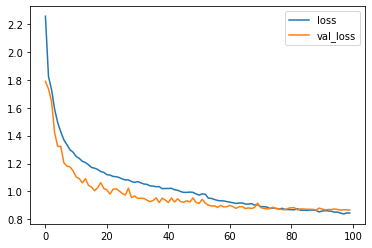

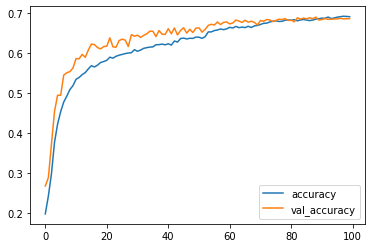

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN12_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN12_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN12.h5')

In [ ]:
with open(saved_model_directory +'/history_CNN12', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

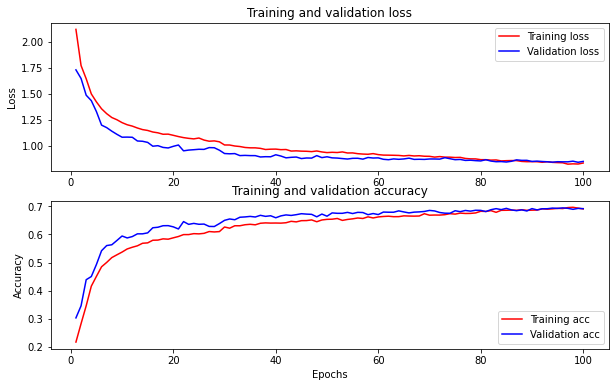

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN12.jpg')

## CNN13

decrease droupout -1

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
793/793 [==============================] - 21s 21ms/step - loss: 2.0191 - accuracy: 0.2315 - val_loss: 1.6696 - val_accuracy: 0.3410 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 15s 19ms/step - loss: 1.7085 - accuracy: 0.3215 - val_loss: 1.5116 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 15s 19ms/step - loss: 1.5414 - accuracy: 0.3965 - val_loss: 1.3535 - val_accuracy: 0.4921 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 15s 19ms/step - loss: 1.4294 - accuracy: 0.4525 - val_loss: 1.3129 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 15s 19ms/step - loss: 1.3532 - accuracy: 0.4801 - val_loss: 1.2270 - val_accuracy: 0.5320 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 15s 19ms/step - loss: 1.3046 - accuracy: 0.5037 - val_loss: 1.2395 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

110/110 [==============================] - 1s 6ms/step - loss: 0.8861 - accuracy: 0.6797


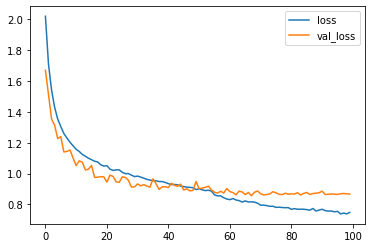

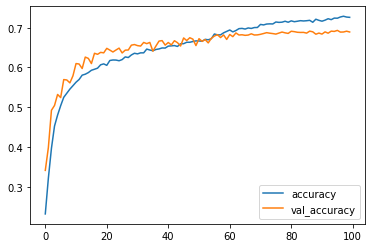

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN13_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN13_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN13.h5')

with open(saved_model_directory +'/history_CNN13', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

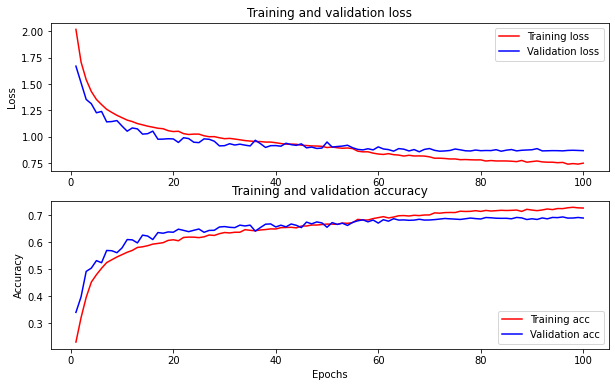

In [ ]:
with open(saved_model_directory +'/history_CNN13', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN13.jpg')

#Transfer learning

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(25387, 48, 48, 1)
(25387,)
(7000, 48, 48, 1)
(7000,)
(3500, 48, 48, 1)
(3500,)


In [42]:
X_train_rgb = tf.constant(X_train)
X_train_rgb = tf.image.grayscale_to_rgb(X_train_rgb)

X_test_rgb = tf.constant(X_test)
X_test_rgb = tf.image.grayscale_to_rgb(X_test_rgb)

X_valid_rgb = tf.constant(X_valid)
X_valid_rgb = tf.image.grayscale_to_rgb(X_valid_rgb)

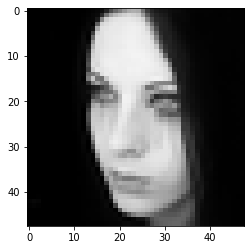

In [43]:
plt.imshow(X_train_rgb[569])

##VGG16

In [72]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [60]:
# Freeze four convolution layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [61]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [62]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train_rgb)

In [63]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = vgg_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [71]:
model.get_config()["layers"]

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': (None, 48, 48, 3),
   'dtype': 'float32',
   'name': 'input_1',
   'ragged': False,
   'sparse': False},
  'inbound_nodes': [],
  'name': 'input_1'},
 {'class_name': 'Functional',
  'config': {'input_layers': [['input_4', 0, 0]],
   'layers': [{'class_name': 'InputLayer',
     'config': {'batch_input_shape': (None, 48, 48, 3),
      'dtype': 'float32',
      'name': 'input_4',
      'ragged': False,
      'sparse': False},
     'inbound_nodes': [],
     'name': 'input_4'},
    {'class_name': 'Conv2D',
     'config': {'activation': 'relu',
      'activity_regularizer': None,
      'bias_constraint': None,
      'bias_initializer': {'class_name': 'Zeros', 'config': {}},
      'bias_regularizer': None,
      'data_format': 'channels_last',
      'dilation_rate': (1, 1),
      'dtype': 'float32',
      'filters': 64,
      'groups': 1,
      'kernel_constraint': None,
      'kernel_initializer': {'class_name': 'GlorotUniform',

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799  

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

batch_size = 32 
history = model.fit(data_generator4.flow(X_train_rgb, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid_rgb, y_valid),
                    steps_per_epoch=len(X_train_rgb) / batch_size,
                    callbacks=[lr_reduce],
                    use_multiprocessing=True)

model.evaluate(X_test_rgb, y_test)

Epoch 1/100
793/793 [==============================] - 32s 26ms/step - loss: 1.7319 - accuracy: 0.3026 - val_loss: 1.5889 - val_accuracy: 0.3920 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 21s 27ms/step - loss: 1.6020 - accuracy: 0.3901 - val_loss: 1.4463 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 21s 26ms/step - loss: 1.5306 - accuracy: 0.4116 - val_loss: 1.4249 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 21s 27ms/step - loss: 1.5024 - accuracy: 0.4230 - val_loss: 1.3932 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 21s 27ms/step - loss: 1.4868 - accuracy: 0.4332 - val_loss: 1.4472 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 21s 26ms/step - loss: 1.4713 - accuracy: 0.4388 - val_loss: 1.3905 - val_accuracy: 0.4660 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

[1.2980512380599976, 0.5142857432365417]

110/110 [==============================] - 1s 9ms/step - loss: 1.2981 - accuracy: 0.5143


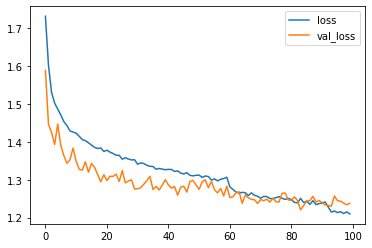

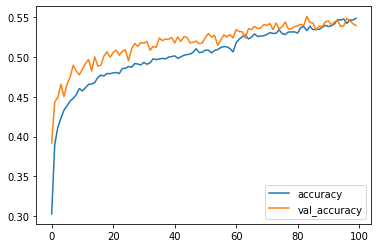

In [ ]:
model.evaluate(X_test_rgb, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'VGG16_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'VGG16_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'VGG16.h5')

with open(saved_model_directory +'/history_VGG16', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

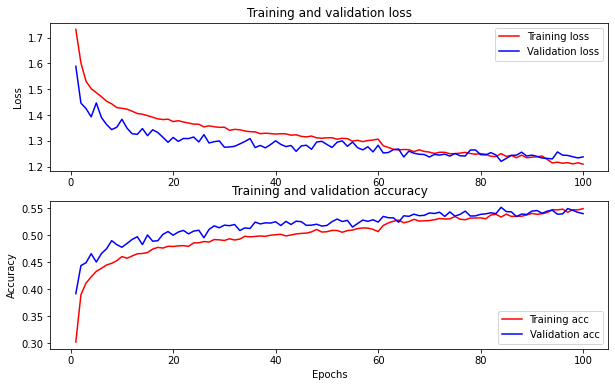

In [ ]:
with open(saved_model_directory +'/history_VGG16', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'VGG16.jpg')

##VGG16_2

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = vgg_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="elu", kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="elu", kernel_initializer='he_normal')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799  

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

batch_size = 32 
history = model.fit(data_generator4.flow(X_train_rgb, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid_rgb, y_valid),
                    steps_per_epoch=len(X_train_rgb) / batch_size,
                    callbacks=[lr_reduce],
                    use_multiprocessing=True)

model.evaluate(X_test_rgb, y_test)

Epoch 1/100
793/793 [==============================] - 38s 30ms/step - loss: 1.8226 - accuracy: 0.2467 - val_loss: 1.8206 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 2/100
793/793 [==============================] - 25s 31ms/step - loss: 2.5593 - accuracy: 0.2544 - val_loss: 1.6549 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/100
793/793 [==============================] - 23s 29ms/step - loss: 1.6691 - accuracy: 0.3335 - val_loss: 1.5311 - val_accuracy: 0.4007 - lr: 0.0010
Epoch 4/100
793/793 [==============================] - 24s 30ms/step - loss: 1.6125 - accuracy: 0.3676 - val_loss: 1.4910 - val_accuracy: 0.4260 - lr: 0.0010
Epoch 5/100
793/793 [==============================] - 23s 29ms/step - loss: 1.5741 - accuracy: 0.3863 - val_loss: 1.5268 - val_accuracy: 0.3907 - lr: 0.0010
Epoch 6/100
793/793 [==============================] - 23s 29ms/step - loss: 1.5517 - accuracy: 0.3970 - val_loss: 1.4591 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 7/100
793/793 [==============================]

[1.3868900537490845, 0.4708571434020996]

110/110 [==============================] - 1s 13ms/step - loss: 1.3869 - accuracy: 0.4709


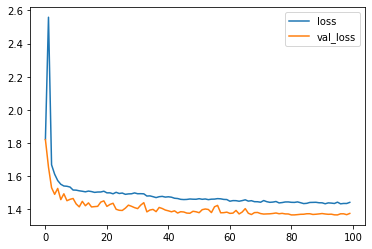

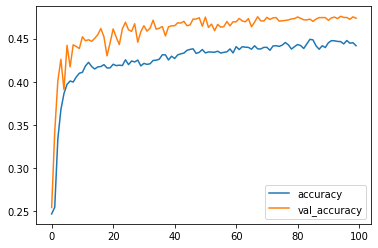

In [ ]:
model.evaluate(X_test_rgb, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'VGG16_2_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'VGG16_2_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'VGG16_2.h5')

with open(saved_model_directory +'/history_VGG16_2', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

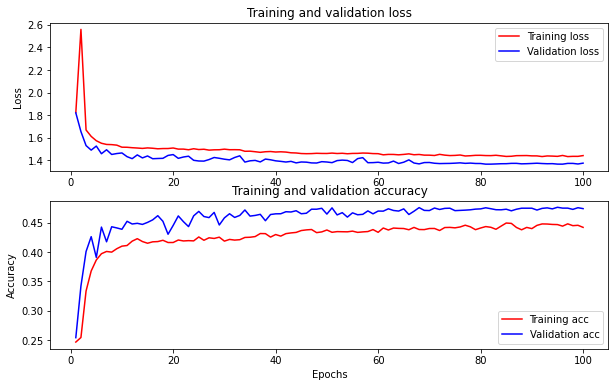

In [ ]:
with open(saved_model_directory +'/history_VGG16_2', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'VGG16_2.jpg')

## ResNet50

In [ ]:
print(X_train_rgb.shape)
print(X_valid_rgb.shape)
print(X_test_rgb.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(25387, 48, 48, 3)
(7000, 48, 48, 3)
(3500, 48, 48, 3)
(25387,)
(7000,)
(3500,)


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train_rgb)

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# Freeze four convolution layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

NameError: ignored

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 7)                 1799  

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

batch_size = 32 
history = model.fit(data_generator4.flow(X_train_rgb, y_train, batch_size=batch_size),
                    epochs=10, validation_data=(X_valid_rgb, y_valid),
                    steps_per_epoch=len(X_train_rgb) / batch_size,
                    callbacks=[lr_reduce],
                    use_multiprocessing=True)

model.evaluate(X_test_rgb, y_test)

Epoch 1/10
793/793 [==============================] - 29s 32ms/step - loss: 1.8144 - accuracy: 0.2488 - val_loss: 1.8161 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 2/10
793/793 [==============================] - 23s 29ms/step - loss: 1.8130 - accuracy: 0.2487 - val_loss: 1.8160 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 3/10
793/793 [==============================] - 23s 29ms/step - loss: 1.8116 - accuracy: 0.2493 - val_loss: 1.8148 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 4/10
793/793 [==============================] - 23s 29ms/step - loss: 1.8122 - accuracy: 0.2494 - val_loss: 1.8151 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 5/10
793/793 [==============================] - 23s 29ms/step - loss: 1.8109 - accuracy: 0.2494 - val_loss: 1.8162 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 6/10
793/793 [==============================] - 24s 30ms/step - loss: 1.8109 - accuracy: 0.2494 - val_loss: 1.8168 - val_accuracy: 0.2541 - lr: 0.0010
Epoch 7/10
793/793 [==============================] - 23s 

[1.8047094345092773, 0.2508571445941925]

110/110 [==============================] - 2s 16ms/step - loss: 1.8047 - accuracy: 0.2509


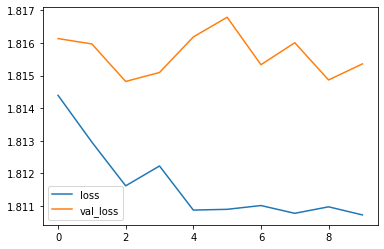

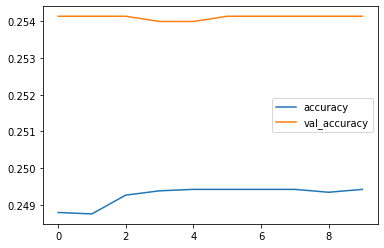

In [ ]:
model.evaluate(X_test_rgb, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'Restnet50_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'Restnet50_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'Restnet50.h5')

with open(saved_model_directory +'/history_Restnet50', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

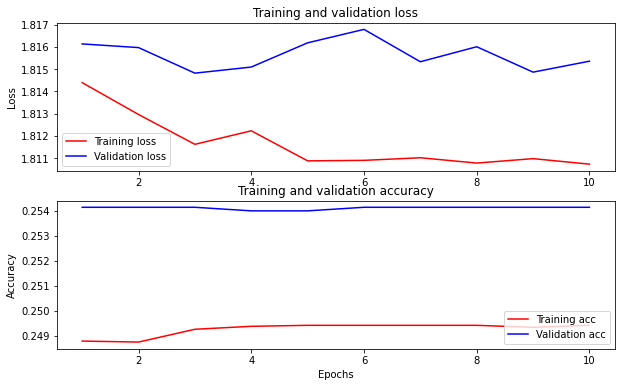

In [ ]:
with open(saved_model_directory +'/history_Restnet50', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'Restnet50.jpg')

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = base_model(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
history = model.fit(data_generator4.flow(X_train_rgb, y_train),
                    epochs=25, validation_data=(X_valid_rgb, y_valid),
                    callbacks=[lrd, es],
                    use_multiprocessing=True)

model.evaluate(X_test_rgb, y_test)

Epoch 1/25
794/794 [==============================] - 30s 31ms/step - loss: 1.9784 - accuracy: 0.1995 - val_loss: 1.9283 - val_accuracy: 0.1730 - lr: 0.0010
Epoch 2/25
794/794 [==============================] - 23s 29ms/step - loss: 1.8318 - accuracy: 0.2350 - val_loss: 1.8154 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 3/25
794/794 [==============================] - 23s 29ms/step - loss: 1.8166 - accuracy: 0.2422 - val_loss: 1.8024 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 4/25
794/794 [==============================] - 23s 29ms/step - loss: 1.8091 - accuracy: 0.2460 - val_loss: 1.7954 - val_accuracy: 0.2650 - lr: 0.0010
Epoch 5/25
794/794 [==============================] - 24s 30ms/step - loss: 1.8059 - accuracy: 0.2478 - val_loss: 1.7946 - val_accuracy: 0.2623 - lr: 0.0010
Epoch 6/25
794/794 [==============================] - 24s 30ms/step - loss: 1.8021 - accuracy: 0.2491 - val_loss: 1.7855 - val_accuracy: 0.2574 - lr: 0.0010
Epoch 7/25
794/794 [==============================] - 24s 

[1.7405399084091187, 0.2840000092983246]

110/110 [==============================] - 2s 18ms/step - loss: 1.7405 - accuracy: 0.2840


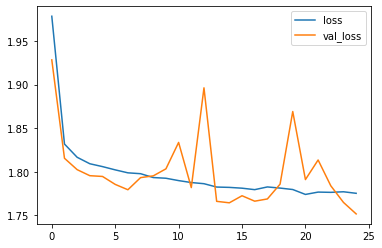

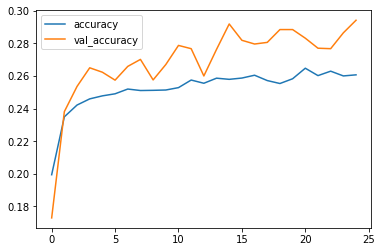

In [ ]:
model.evaluate(X_test_rgb, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'Restnet_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'Restnet_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'Restnet50.h5')

with open(saved_model_directory +'/history_Restnet50', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

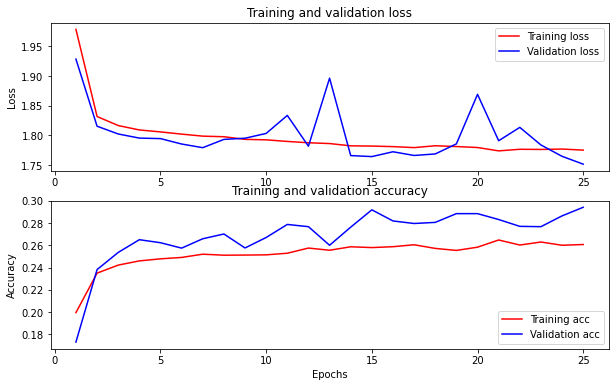

In [ ]:
with open(saved_model_directory +'/history_Restnet50', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'Restnet50.jpg')

## PublicTest faces only data images

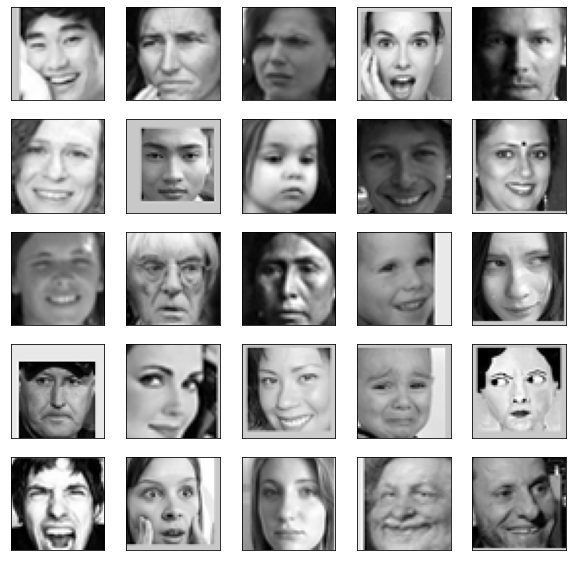

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
    #plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

# Predict on public test set

In [ ]:
#1136
X_public = images_test_public
print(X_public.shape)

(1136, 48, 48)


In [ ]:
X_public = X_public.reshape(-1, 48, 48, 1)
print(X_public.shape)

(1136, 48, 48, 1)


In [ ]:
X_public_pred = (model.predict(X_public) > 0.5).astype("int32")
X_public_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
result = []
for i in range(len(X_public_pred)):
  r = np.argmax(X_public_pred[i])
  result.append(r)
X_public_pred_arr = np.array(result)
X_public_pred_arr

array([3, 0, 0, ..., 3, 4, 3])

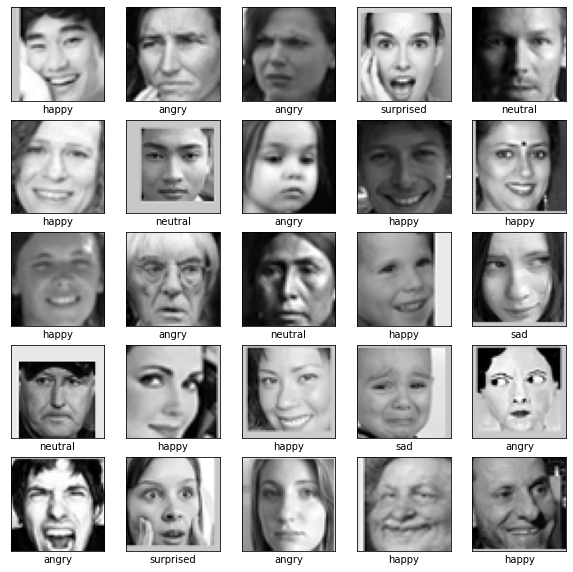

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
    plt.xlabel( EMOTIONS[ X_public_pred_arr[i] ] )
plt.show()

In [ ]:
id = []
for i in range(len(X_public_pred_arr)):
  id.append(i)

public_pred = X_public_pred_arr.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate PUBLIC test csvs
output.to_csv(join(dataset_directory, '46318461_conv_predictions_CNN10_FER2013.csv'), index=False, header=True,  encoding='utf-8')

End here